# Human in the Loop

Langgraph supports different ways of interrumpting the control flow of a graph and allow for human intervention. The interruption of the states 

---

In [ ]:
from dotenv import load_dotenv
import pandas as pd
from pathlib import Path
import json
from dotenv import load_dotenv
import os 
import pprint
from IPython.display import Image, display
from typing import TypedDict, Annotated, Literal, Dict, Any

Import the necessary classes from **Langchain** and **Langgraph**

In [60]:
from langgraph.graph import StateGraph, END
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import MemorySaver


In [61]:
# %pip install rich

In [62]:
# Load environment variables from .env file
load_dotenv()

True

We define an LLM model to use in a zero-shot mode to answer user questions

In [63]:
llm_model = "openai:"+os.getenv("OPENAI_MODEL")
print(llm_model)
llm = init_chat_model(llm_model, temperature=0)

openai:gpt-4o-mini


In [64]:
# Define the state schema
class HumanInTheLoopState(TypedDict):
    question: str  # User's original question
    ai_draft: str  # AI's initial response draft
    human_feedback: str  # Human reviewer's feedback
    final_response: str  # Final response after incorporating feedback

Definition of the nodes for the graph

In [73]:
def draft_response(state: Dict[str, Any]) -> Dict[str, Any]:
    """AI drafts an initial response to the user's question"""
    question = state["question"]
    
    # In a real application, this would use an LLM to generate a response
    #Â draft = f"DRAFT: Here's my initial answer to: '{question}'"
    draft = llm.invoke("Answer the following question: "+question)
    
    print(f"\nðŸ¤– AI has drafted an initial response")
    #Â pprint.pprint(f"{draft.content}\n")
    return {"ai_draft": draft.content}

def get_human_feedback(state: Dict[str, Any]) -> Dict[str, Any]:
    """Collect feedback from a human reviewer"""
    # In a real application, this would be implemented with a UI
    # or messaging platform to collect human input
    print("\nðŸ‘‹ HUMAN REVIEW REQUIRED!\n")
    print(f"Original question: {state['question']}")
    #Â print(f"AI draft: {state['ai_draft']}")
    renderable_markup = Markdown(f"**AI draft:** {state['ai_draft']}")
    console.print(renderable_markup)

    # Simulating human input via console
    feedback = input("\nPlease provide feedback or type 'approve' to accept: ")
    
    print(f"\nðŸ‘¤ Human provided feedback: {feedback}\n")
    return {"human_feedback": feedback}

def decide_next_step(state: Dict[str, Any]) -> Literal["revise", "finalize"]:
    """Decide whether to revise the response or finalize it"""
    if state["human_feedback"].lower() == "approve":
        return "finalize"
    else:
        return "revise"

def revise_response(state: Dict[str, Any]) -> Dict[str, Any]:
    """Revise the response based on human feedback"""
    # In a real application, this would use an LLM to incorporate feedback
    old_draft = "For the following question: "+ state['question']+ ", you previously provided this answer: "+ state['ai_draft']
    revised_response = llm.invoke(old_draft + ". The user provided feedback: "+ state['human_feedback']+ ". Please revisit it and provide a new answer.")
    #Â revised_response = f"REVISED: I've updated my answer based on feedback: '{state['human_feedback']}'"
    
    print(f"\nðŸ¤– AI has revised the response.")
    #Â pprint.pprint(f"{revised_response.content}\n")
    return {"ai_draft": revised_response.content}

def finalize_response(state: Dict[str, Any]) -> Dict[str, Any]:
    """Finalize the response and return to the user"""
    
    print(f"\nâœ… Final response ready:")
    renderable_markup = Markdown(f"{state['ai_draft']}\n")
    console.print(renderable_markup)

    return {"final_response": state['ai_draft']}

Assembling the graph

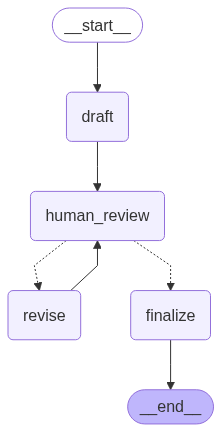

In [74]:
# Initialize the graph
graph = StateGraph(HumanInTheLoopState)

# Add nodes
graph.add_node("draft", draft_response)
graph.add_node("human_review", get_human_feedback)  # Renamed from "human_feedback"
graph.add_node("revise", revise_response)
graph.add_node("finalize", finalize_response)

# Define the flow
graph.add_edge("draft", "human_review")
graph.add_conditional_edges(
    "human_review",
    decide_next_step,
    {
        "revise": "revise",
        "finalize": "finalize"
    }
)
graph.add_edge("revise", "human_review")
graph.add_edge("finalize", END)

# Set the entry point
graph.set_entry_point("draft")

checkpointer = MemorySaver()
workflow = graph.compile(checkpointer=checkpointer)

display(Image(workflow.get_graph().draw_mermaid_png()))

In [75]:
from rich.console import Console
from rich.markdown import Markdown

# This console is only for rendering Markup content nicely
console = Console()

Testing a simple "approve" interruption

In [76]:
# Initial state with a user question
query = "What's the best way to implement HITL systems?"

initial_state = {
    "question": query,
    "ai_draft": "",
    "human_feedback": "",
    "final_response": "",
    "thread_id": 1
}

# Run the workflow
config = {"configurable": {"thread_id": 1}}
for output in workflow.stream(initial_state, config):
    # In a production application, you would handle these events appropriately
    pass
    
# Final state contains the complete conversation
print("\n=== WORKFLOW COMPLETED ===")


ðŸ¤– AI has drafted an initial response

ðŸ‘‹ HUMAN REVIEW REQUIRED!

Original question: What's the best way to implement HITL systems?


AI draft: Implementing Human-in-the-Loop (HITL) systems effectively involves several key steps and considerations. 
Hereâ€™s a structured approach to ensure successful implementation:                                                  

  1 Define Objectives and Use Cases:                                                                               
     â€¢ Clearly outline the goals of the HITL system. Identify specific tasks where human input is necessary, such  
       as data labeling, decision-making, or quality assurance.                                                    
     â€¢ Determine the use cases where HITL can add value, such as in machine learning model training, real-time     
       decision support, or error correction.                                                                      
  2 Select Appropriate Technology:                                                                                 
     â€¢ Choose the right tools and platforms that support HITL workflows. This may include machine learning         
       frameworks, data annotation tools, or custom software solutions.                                            
     â€¢ Ensure that the technology can facilitate seamless interaction between humans and machines.                 
  3 Design the Workflow:                                                                                           
     â€¢ Create a clear workflow that integrates human input at critical points. Define how tasks will be assigned to
       humans, how feedback will be collected, and how the system will learn from human input.                     
     â€¢ Consider using iterative processes where human feedback can continuously improve the system.                
  4 User Interface and Experience:                                                                                 
     â€¢ Develop an intuitive user interface that allows human operators to interact with the system easily. The     
       interface should minimize cognitive load and provide clear instructions.                                    
     â€¢ Ensure that the system provides relevant context and information to assist human decision-making.           
  5 Training and Onboarding:                                                                                       
     â€¢ Provide comprehensive training for users who will interact with the HITL system. This should cover both the 
       technical aspects and the rationale behind the systemâ€™s design.                                             
     â€¢ Offer ongoing support and resources to help users adapt to the system.                                      
  6 Feedback Mechanisms:                                                                                           
     â€¢ Implement robust feedback loops where human input can be used to refine and improve the system. This may    
       involve collecting data on user interactions and outcomes.                                                  
     â€¢ Regularly review and analyze feedback to identify areas for improvement.                                    
  7 Monitoring and Evaluation:                                                                                     
     â€¢ Continuously monitor the performance of the HITL system. Evaluate how well it meets its objectives and the  
       quality of human contributions.                                                                             
     â€¢ Use metrics to assess the effectiveness of the system, such as accuracy, efficiency, and user satisfaction. 
  8 Iterate and Improve:                                                                                           
     â€¢ Treat the HITL system as a living project that requires regular updates and improvements based on user      
       feedback and performance data.                                                                              
     â€¢ Be open to m


ðŸ‘¤ Human provided feedback: approve


âœ… Final response ready:


Implementing Human-in-the-Loop (HITL) systems effectively involves several key steps and considerations. Hereâ€™s a  
structured approach to ensure successful implementation:                                                           

  1 Define Objectives and Use Cases:                                                                               
     â€¢ Clearly outline the goals of the HITL system. Identify specific tasks where human input is necessary, such  
       as data labeling, decision-making, or quality assurance.                                                    
     â€¢ Determine the use cases where HITL can add value, such as in machine learning model training, real-time     
       decision support, or error correction.                                                                      
  2 Select Appropriate Technology:                                                                                 
     â€¢ Choose the right tools and platforms that support HITL workflows. This may include machine learning         
       frameworks, data annotation tools, or custom software solutions.                                            
     â€¢ Ensure that the technology can facilitate seamless interaction between humans and machines.                 
  3 Design the Workflow:                                                                                           
     â€¢ Create a clear workflow that integrates human input at critical points. Define how tasks will be assigned to
       humans, how feedback will be collected, and how the system will learn from human input.                     
     â€¢ Consider using iterative processes where human feedback can continuously improve the system.                
  4 User Interface and Experience:                                                                                 
     â€¢ Develop an intuitive user interface that allows human operators to interact with the system easily. The     
       interface should minimize cognitive load and provide clear instructions.                                    
     â€¢ Ensure that the system provides relevant context and information to assist human decision-making.           
  5 Training and Onboarding:                                                                                       
     â€¢ Provide comprehensive training for users who will interact with the HITL system. This should cover both the 
       technical aspects and the rationale behind the systemâ€™s design.                                             
     â€¢ Offer ongoing support and resources to help users adapt to the system.                                      
  6 Feedback Mechanisms:                                                                                           
     â€¢ Implement robust feedback loops where human input can be used to refine and improve the system. This may    
       involve collecting data on user interactions and outcomes.                                                  
     â€¢ Regularly review and analyze feedback to identify areas for improvement.                                    
  7 Monitoring and Evaluation:                                                                                     
     â€¢ Continuously monitor the performance of the HITL system. Evaluate how well it meets its objectives and the  
       quality of human contributions.                                                                             
     â€¢ Use metrics to assess the effectiveness of the system, such as accuracy, efficiency, and user satisfaction. 
  8 Iterate and Improve:                                                                                           
     â€¢ Treat the HITL system as a living project that requires regular updates and improvements based on user      
       feedback and performance data.                                                                              
     â€¢ Be open to m


=== WORKFLOW COMPLETED ===


---

In general, when a graph is interrupted, its state is persisted until the graph is resumed (from the interrupted node).

In [ ]:
# If the graph is interrumpted, the status per thread can be checked with:

#Â workflow.get_state(thread_config).tasks[0].interrupts[0].value

()